# Project in data science: Travel Agency
(This is a direct copy of the assignment)

You are in charge of a major travel agency in
the United States of America. Your agency
doesn’t have its own airline, therefore you
assign travelers to flights based on their
wishes and budget. As of late, you have
started receiving many complaints about
delayed and cancelled flights. The bookings
are rolling in for next summer holiday period
(August 2022) and you decide to roll up your
sleeves and develop a machine learning model
to predict the amount of delay a particular
flight will experience. To this end, you start
looking for data and you stumble upon a
dataset which provides information on all known delays in the months March, April, May, June and
July of 2019. Moreover, you find the flight schedule for August of 2022! You can therefore use the
2019 data in order to predict the amount of delay flights will be experiencing next summer!
This assignment is by no means straightforward and should contain at least the following steps:

* Exploratory data analysis: Is the data clean? What data do we really need to use? What factors are more/less important? Can you visualize the data?
* Determine a good performance measure that can be used to evaluate your machine learning model.
* Split the known data into a train/test set and start developing models. Try out many models in order to obtain good predictions on the test set.

In total there are 4 separate files:
* historic_data.csv : containing the labeled data for March, April, May, June and July of 2019.
* future_data.csv : containing the unlabeled data for August 2022.
* airlines.csv : containing the full names of airlines which appear in the data.
* airports.csv : containing additional information for the airports which occur in the data.



## Load in necessary packages and data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import re

airlines = pd.read_csv('Data\\airlines.csv')
airports = pd.read_csv('Data\\airports.csv')
past_data = pd.read_csv('Data\\historic_data.csv')
august_data = pd.read_csv('Data\\future_data.csv')

## Inspect the data and do exploratory statistics

### Inspecting the data

In [6]:
past_data.head(10)

past_data['CANCELLED'].shape

(2458628,)

In [3]:
past_data.columns.values

array(['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL',
       'ARRIVAL_TIME', 'AIRLINE', 'FLIGHT_NUMBER', 'TAIL_NUMBER',
       'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'DEPARTURE_DELAY',
       'TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'ELAPSED_TIME',
       'AIR_TIME', 'DISTANCE', 'WHEELS_ON', 'TAXI_IN', 'CANCELLED',
       'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY',
       'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'],
      dtype=object)

Looking at these data, we can notice a couple of things:
* There are multiple reasons a flight can be delayed. This data set splits up these reasons into different columns (i.e. "delay caused by weather", "delay caused by airline", etc.). The clients don't care about this, they just care about delay in total. It might therefore be good to aggregate all these columns into one 'Total delay' column.
* It is unlikely that __FLIGHT_NUMBER__ and __TAIL_NUMBER__ will have any effect on the delay. They should therefore be dropped.
* Similarly, I don't think that __TAXI_OUT__, __WHEELS_OFF__, __WHEELS_ON__ and __TAXI_IN__ have and influence on the total delay. However, since it is not absolutely clear that this is the case, further analysis needs to be done. Also, this information cannot be used to make predictions for the delay of a flight that will fly in a couple of months from now.
* There are a lot of NaN's in the data. This should be handled appropriately.

Furthermore, the following relations seem to hold (check it using code below!)
* __DEPARTURE_TIME__ - __SCHEDULED_DEPARTURE__ = __DEPARTURE_DELAY__
* __SCHEDULED_ARRIVAL__ - __SCHEDULED_DEPARTURE__ = __SCHEDULED_TIME__
    * THIS DOES NOT HOLD! __SCHEDULED_TIME__ is sometimes off by one or two full houres. This could be due to timezone differences!

In [4]:
# Randomly sample a small data set from past_data to work on. Modify it.
df = past_data.sample(n=300, replace=False)
df.reset_index(inplace=True, drop=True)

# Get all date-time strings into the same format (for this, assume that the date of Departure, scheduled arrival
# and actual arrival are all the same. This possible mistake will be corrected for in the methods surrounding these
# datetimes.)
# for index in range(df.shape[0]):
#     datepart = df.loc[index, 'SCHEDULED_DEPARTURE'][0:10:1]
#     for col in ['DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']:
#         if (df.at[index, 'CANCELLED'] != 1) | (col == 'SCHEDULED_ARRIVAL'):
#             df.at[index, col] = datepart + " " + df.at[index, col]

for index in range(df.shape[0]):
    datepart = df.loc[index, 'SCHEDULED_DEPARTURE'][0:10:1]
    for col in ['DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME']:
        if not pd.isnull(df.loc[index, col]):
            df.at[index, col] = datepart + " " + df.loc[index, col]
            
# Convert string values that indicate dates and times to datetime objects
toConvert = ['SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'SCHEDULED_ARRIVAL', 
             'ARRIVAL_TIME']
for col in toConvert:
    df[col] = pd.to_datetime(df[col])

# Create a column containing the total delay
DelayCol = [col for col in df.columns.values if "DELAY" in col]
df['TOTAL_DELAY'] = df[DelayCol].sum(axis=1, skipna=True)

# The unnecessary columns are dropped later

df.head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,DEPARTURE_DELAY,...,WHEELS_ON,TAXI_IN,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,TOTAL_DELAY
0,2019-06-21 15:50:00,2019-06-21 15:51:00,2019-06-21 17:08:00,2019-06-21 16:45:00,DL,2483,N958DL,ATL,OKC,1.0,...,1641.0,4.0,0,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,2019-03-29 14:25:00,2019-03-29 14:41:00,2019-03-29 19:53:00,2019-03-29 19:54:00,DL,1240,N911DA,TUS,ATL,16.0,...,1944.0,10.0,0,NaN,NaN,NaN,NaN,NaN,NaN,16.0
2,2019-06-02 15:25:00,2019-06-02 15:43:00,2019-06-02 16:34:00,2019-06-02 16:50:00,EV,3269,N14904,LFT,IAH,18.0,...,1644.0,6.0,0,NaN,0.0,0.0,0.0,16.0,0.0,34.0
3,2019-04-23 15:11:00,2019-04-23 16:28:00,2019-04-23 18:44:00,2019-04-23 19:58:00,UA,2027,N420UA,DEN,ORD,77.0,...,1933.0,25.0,0,NaN,74.0,0.0,0.0,0.0,0.0,151.0
4,2019-06-02 05:35:00,2019-06-02 05:31:00,2019-06-02 06:35:00,2019-06-02 06:34:00,EV,4740,N14573,GRB,ORD,-4.0,...,620.0,14.0,0,NaN,NaN,NaN,NaN,NaN,NaN,-4.0


In [5]:
# Create a function that computes col1 - col2
def getDurationInMinutes(col1, col2):
    return (df[col1] - df[col2]).apply(lambda x: x.seconds) / 60

# def getDurationInMinutes(col1, col2):
#     return (df[col1] - df[col2])

# Define some useful variables/constants
MINUTES_PER_DAY = 1440
nonConforming = []

# Assert that DEPARTURE_TIME - SCHEDULED_DEPARTURE = DEPARTURE_DELAY. In doing so, account for the fact that planes might leave
# the next/previous day (which was originally not indicated in DEPARTURE_TIME and was hence assumed to be the same day when
# creating the variable. A day consists of 1440 minutes).
COMPUTED_DEP_DEL = getDurationInMinutes('DEPARTURE_TIME', 'SCHEDULED_DEPARTURE')
for index in range(df.shape[0]):
    if ((COMPUTED_DEP_DEL[index] != df.at[index, 'DEPARTURE_DELAY']) & 
        (COMPUTED_DEP_DEL[index] + MINUTES_PER_DAY != df.at[index, 'DEPARTURE_DELAY']) & 
        (COMPUTED_DEP_DEL[index] - MINUTES_PER_DAY != df.at[index, 'DEPARTURE_DELAY'])):
            nonConforming.append(index)

# Assert that ARRIVAL_TIME - DEPARTURE_TIME = ELAPSED_TIME
COMPUTED_SCHED_TIME = getDurationInMinutes('SCHEDULED_ARRIVAL', 'SCHEDULED_DEPARTURE')
for index in range(df.shape[0]):
    if ((COMPUTED_SCHED_TIME[index] != df.at[index, 'SCHEDULED_TIME']) & 
        (COMPUTED_SCHED_TIME[index] + MINUTES_PER_DAY != df.at[index, 'SCHEDULED_TIME']) & 
        (COMPUTED_SCHED_TIME[index] - MINUTES_PER_DAY != df.at[index, 'SCHEDULED_TIME'])):
            nonConforming.append(index)
            
# df.loc[nonConforming, ['ARRIVAL_TIME', 'SCHEDULED_DEPARTURE', 'ELAPSED_TIME']]
df.loc[nonConforming, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'SCHEDULED_TIME']]

,SCHEDULED_DEPARTURE,SCHEDULED_ARRIVAL,SCHEDULED_TIME
75,2019-04-06 09:40:00,2019-04-06 12:05:00,145.0
121,2019-05-17 22:02:00,2019-05-17 01:00:00,118.0
163,2019-06-25 13:05:00,2019-06-25 15:00:00,115.0
241,2019-06-04 15:25:00,2019-06-04 17:20:00,115.0
268,2019-06-26 21:16:00,2019-06-26 23:24:00,188.0
...,...,...,...
288,2019-04-16 10:25:00,2019-04-16 11:48:00,143.0
289,2019-05-06 19:15:00,2019-05-06 22:43:00,148.0
292,2019-06-08 11:54:00,2019-06-08 15:28:00,154.0
293,2019-03-19 12:50:00,2019-03-19 14:00:00,130.0


In [6]:
# Drop columns 'FLIGHT_NUMBER', 'TAIL_NUMBER' and 'CANCELLATION_REASON'.
# Also drop the specific delay columns.
df.drop(columns=DelayCol, inplace=True)
df.drop(columns=['FLIGHT_NUMBER', 'TAIL_NUMBER', 'CANCELLATION_REASON'], inplace=True)

df.head()

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,CANCELLED,TOTAL_DELAY
0,2019-06-21 15:50:00,2019-06-21 15:51:00,2019-06-21 17:08:00,2019-06-21 16:45:00,DL,ATL,OKC,15.0,1606.0,138.0,114.0,95.0,761,1641.0,4.0,0,1.0
1,2019-03-29 14:25:00,2019-03-29 14:41:00,2019-03-29 19:53:00,2019-03-29 19:54:00,DL,TUS,ATL,16.0,1457.0,208.0,193.0,167.0,1541,1944.0,10.0,0,16.0
2,2019-06-02 15:25:00,2019-06-02 15:43:00,2019-06-02 16:34:00,2019-06-02 16:50:00,EV,LFT,IAH,21.0,1604.0,69.0,67.0,40.0,201,1644.0,6.0,0,34.0
3,2019-04-23 15:11:00,2019-04-23 16:28:00,2019-04-23 18:44:00,2019-04-23 19:58:00,UA,DEN,ORD,10.0,1638.0,153.0,150.0,115.0,888,1933.0,25.0,0,151.0
4,2019-06-02 05:35:00,2019-06-02 05:31:00,2019-06-02 06:35:00,2019-06-02 06:34:00,EV,GRB,ORD,8.0,539.0,60.0,63.0,41.0,173,620.0,14.0,0,-4.0


### Exploratory analysis
We will investigate/explore the folling:
* How are the data points distributed?
    * Create a box plot for each numeric column
    * Are there some strange observations?
* Are there missing values? How many?
* Are their trends when grouping data by Airline/Origin_airport/destination_airport?
* Are there multicollinearity issues?
* Maybe perform a PCA analysis --> See visualization

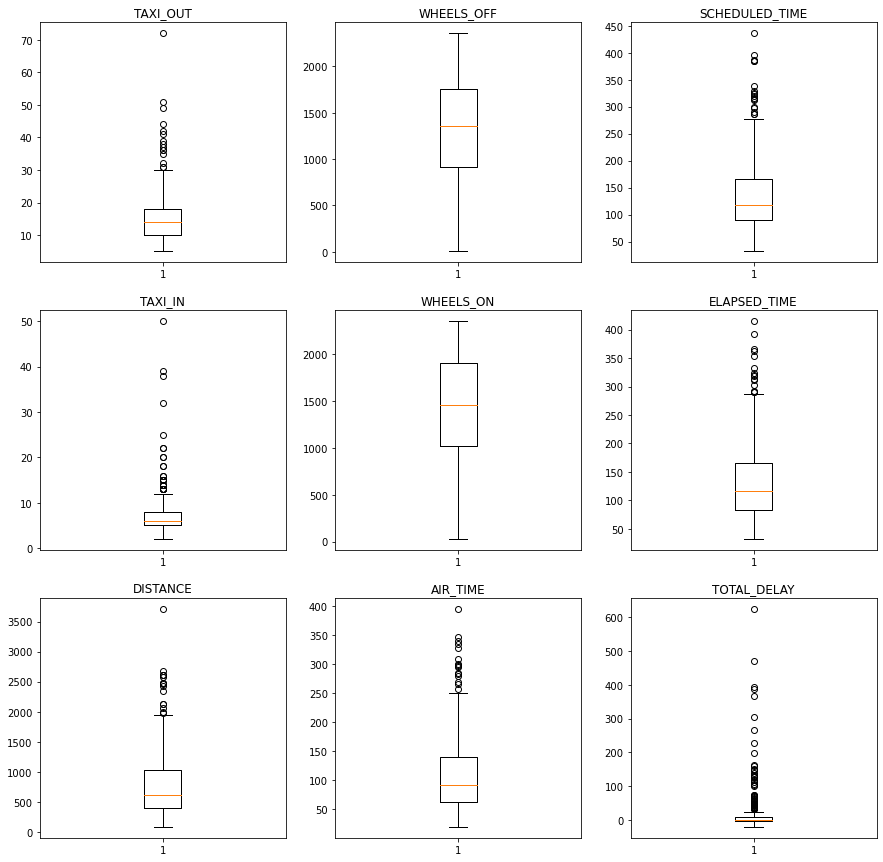

In [7]:
colsOfInterest = ['TAXI_OUT', 'WHEELS_OFF', 'SCHEDULED_TIME', 'TAXI_IN', 'WHEELS_ON', 'ELAPSED_TIME', 'DISTANCE', 
                  'AIR_TIME', 'TOTAL_DELAY']

fig, axs = plt.subplots(3, 3)
for i in range(3):
    for j in range(3):
        col = colsOfInterest[i*3+j]
        axs[i,j].boxplot(df[col][~np.isnan(df[col])])
        axs[i,j].set_title(col)

fig.set_figheight(15)
fig.set_figwidth(15)
    
plt.show()

There are no immediately obvious outlying/weird observations.

In [8]:
df[df.isna().any(axis=1) | df['CANCELLED'] == 1]

,SCHEDULED_DEPARTURE,DEPARTURE_TIME,SCHEDULED_ARRIVAL,ARRIVAL_TIME,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,ELAPSED_TIME,AIR_TIME,DISTANCE,WHEELS_ON,TAXI_IN,CANCELLED,TOTAL_DELAY
25,2019-06-26 19:30:00,NaT,2019-06-26 20:32:00,NaT,DL,PIT,DTW,NaN,NaN,62.0,NaN,NaN,201,NaN,NaN,1,0.0
43,2019-05-02 17:30:00,NaT,2019-05-02 20:10:00,NaT,WN,ISP,MCO,NaN,NaN,160.0,NaN,NaN,971,NaN,NaN,1,0.0
51,2019-07-29 05:15:00,NaT,2019-07-29 06:19:00,NaT,MQ,SJT,DFW,NaN,NaN,64.0,NaN,NaN,229,NaN,NaN,1,0.0
67,2019-06-26 08:05:00,NaT,2019-06-26 09:35:00,NaT,EV,MOB,IAH,NaN,NaN,90.0,NaN,NaN,427,NaN,NaN,1,0.0
186,2019-04-25 18:57:00,NaT,2019-04-25 21:00:00,NaT,UA,MCO,DEN,NaN,NaN,243.0,NaN,NaN,1546,NaN,NaN,1,0.0
189,2019-06-26 15:31:00,2019-06-26 15:27:00,2019-06-26 17:36:00,NaT,MQ,OKC,ORD,NaN,NaN,125.0,NaN,NaN,693,NaN,NaN,1,-4.0
209,2019-03-16 12:44:00,NaT,2019-03-16 13:50:00,NaT,OO,PHX,SFO,NaN,NaN,126.0,NaN,NaN,651,NaN,NaN,1,0.0
255,2019-03-01 19:35:00,NaT,2019-03-01 22:25:00,NaT,WN,MDW,SJC,NaN,NaN,290.0,NaN,NaN,1838,NaN,NaN,1,0.0
262,2019-03-27 06:14:00,NaT,2019-03-27 09:03:00,NaT,UA,PBI,EWR,NaN,NaN,169.0,NaN,NaN,1023,NaN,NaN,1,0.0
286,2019-07-10 22:20:00,2019-07-10 23:54:00,2019-07-10 23:45:00,2019-07-10 03:06:00,WN,ATL,DAL,17.0,11.0,145.0,NaN,NaN,721,258.0,8.0,0,94.0


Missing values seem to only occur when the flight is cancelled.

In [9]:
# df[['TOTAL_DELAY', 'AIRLINE']].groupby(['AIRLINE']).mean().sort_values('TOTAL_DELAY', ascending=False)

# df[['TOTAL_DELAY', 'ORIGIN_AIRPORT']].groupby(['ORIGIN_AIRPORT']).mean().describe()
# df[['TOTAL_DELAY', 'ORIGIN_AIRPORT']].groupby(['ORIGIN_AIRPORT']).mean().sort_values('TOTAL_DELAY', ascending=False)

df[['TOTAL_DELAY', 'DESTINATION_AIRPORT']].groupby(['DESTINATION_AIRPORT']).mean().describe()
df[['TOTAL_DELAY', 'DESTINATION_AIRPORT']].groupby(['DESTINATION_AIRPORT']).mean().sort_values('TOTAL_DELAY', ascending=False)

,TOTAL_DELAY
DESTINATION_AIRPORT,
CDV,225.0
IND,222.0
ISP,179.0
SMF,153.0
LGB,140.0
...,...
BDL,-7.0
ACV,-7.0
MFR,-8.0


The airline seems to have a big effect on the delay. Origin airports in general do not, though there are some exceptions. Same conclusion for destination airports.

In [31]:
# In order to detect multicollinearity, we compute VIF's. This requires some packages.
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor

# We will only need the numeric columns of the data
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
df_numeric = df.select_dtypes(include=numerics)

#find design matrix for linear regression model using 'TOTAL_DELAY' as response variable
cols = df_numeric.columns.values
formula = "TOTAL_DELAY ~ "
for pred in cols:
    if (pred != "TOTAL_DELAY") & (pred != "CANCELLED"):
        formula += pred + "+"
formula = formula[:-1]

y, X = dmatrices(formula, data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif


C:\Users\wille\anaconda3\lib\site-packages\statsmodels\stats\outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,VIF,variable
0,25.556187,Intercept
1,inf,TAXI_OUT
2,1.605519,WHEELS_OFF
3,67.307481,SCHEDULED_TIME
4,inf,ELAPSED_TIME
5,inf,AIR_TIME
6,53.626411,DISTANCE
7,1.605937,WHEELS_ON
8,inf,TAXI_IN


Some of the numerical predictors are perfectly correlated. This is of course to be expected. It is likely the case that 
* __AIR_TIME__ = __WHEELS_OFF__ - __WHEELS_ON__
We therefore drop the __AIR_TIME__ variable and run VIF again

In [33]:
#find design matrix for linear regression model using 'TOTAL_DELAY' as response variable
cols = df_numeric.columns.values
formula = "TOTAL_DELAY ~ "
for pred in cols:
    if (pred != "TOTAL_DELAY") & (pred != "CANCELLED") & (pred != "AIR_TIME"):
        formula += pred + "+"
formula = formula[:-1]

y, X = dmatrices(formula, data=df, return_type='dataframe')

#calculate VIF for each explanatory variable
vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns

#view VIF for each explanatory variable 
vif


,VIF,variable
0,25.556187,Intercept
1,2.015044,TAXI_OUT
2,1.605519,WHEELS_OFF
3,67.307481,SCHEDULED_TIME
4,93.824227,ELAPSED_TIME
5,53.626411,DISTANCE
6,1.605937,WHEELS_ON
7,1.534913,TAXI_IN


Although it would be a stretch to say that multicollinearity is solved, the results are much better. Whilst a normal OLS may not perform well, Ridge or LASSO regression can solve this issue.

### Visualization of the data
* Graph mean delay for each airline/origin_airport/destinationn_airport
* Perhaps other graphs but out of ideas atm...

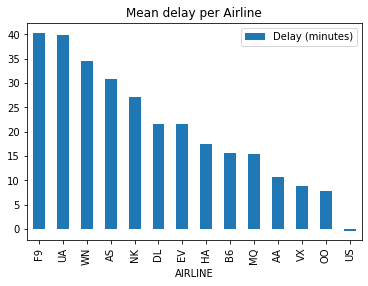

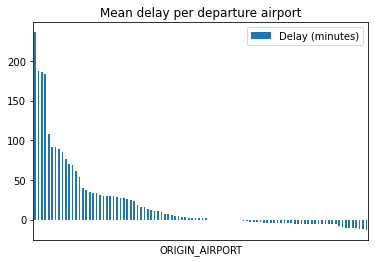

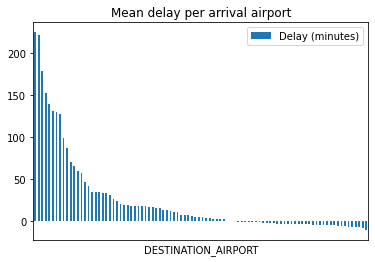

In [114]:
toPlot = df[['TOTAL_DELAY', 'AIRLINE']].groupby(['AIRLINE']).mean().sort_values('TOTAL_DELAY', ascending=False)
toPlot = toPlot.rename(columns={'TOTAL_DELAY': "Delay (minutes)"})
toPlot.plot.bar()
plt.title("Mean delay per Airline")

toPlot = df[['TOTAL_DELAY', 'ORIGIN_AIRPORT']].groupby(['ORIGIN_AIRPORT']).mean().sort_values('TOTAL_DELAY', ascending=False)
toPlot = toPlot.rename(columns={'TOTAL_DELAY': "Delay (minutes)"})
toPlot.plot.bar()
plt.title("Mean delay per departure airport")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off

toPlot = df[['TOTAL_DELAY', 'DESTINATION_AIRPORT']].groupby(['DESTINATION_AIRPORT']).mean().sort_values('TOTAL_DELAY', ascending=False)
toPlot = toPlot.rename(columns={'TOTAL_DELAY': "Delay (minutes)"})
toPlot.plot.bar()
plt.title("Mean delay per arrival airport")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

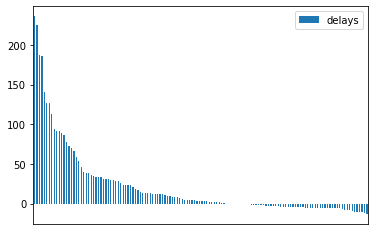

In [113]:
# Get the total delay per airport (irrespective of it being origin/arrival)

airport_codes = airports['IATA_CODE']
delays = []

for airport in airport_codes:
    delay = df[['ORIGIN_AIRPORT', 'DESTINATION_AIRPORT', 'TOTAL_DELAY']].loc[
        (df['ORIGIN_AIRPORT'] == airport) | (df['DESTINATION_AIRPORT'] == airport)].mean(numeric_only=True, skipna=True)
    delays.append(delay.values[0])

# print(delayPerAirport)
d = {"Airports" : airport_codes, "delays": delays}
delayPerAirport = pd.DataFrame(data = d).dropna().sort_values('delays', ascending=False)
delayPerAirport.plot.bar()
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

Theses graph again confirm our conclusion from the previous section. There exist airlines and airports that we should avoid if we want to minimize the expected delay.

## Determine a good performance measure
* Since we want to predict the expected delay on any given flight, a good performance measure would be to compute the __mean squared error of prediction__ on the training data.
* However, we would also like to predict if a flight is going to be cancelled. In theory, this means that the flight has infinite delay, but treating it as such will probably not work very well (probably all flights will then be predicted to be cancelled as MSE of wronlgy classifying a flight that will be cancelled as a flight that wont be cancelled is then infinite).

Some ideas for performance measures are:
* As the end goal is to please the costumers as much as possible, we could work with a function that computes the amount of _displeasement_ a customer experiences for a given amount of delay or cancelled flight.
    * Problem: We would have to construct such a function. The only option is to just guess this function as there is no data about dipleasement available.
    * Source data sets to achieve this may be found on Kaggle though (?)
* Using the MSEP of the delay of the flights. For cancelled flights, we take the delay to be the time untill the next flight takes off (this next flight hence has the same ORIGIN_AIRPORT and DESTINATION_AIRPORT as the cancelled one).
    * Suppose that the cancelled flight was planned for 29/05/2019 and the training data only goes untill 31/05/2022. It could be that there is no next flight. In this case, loop back to the beginning of the data set and continue searching. In the example, suppose then that the first of such flights took place on 5/01/2019 (and assuming the data set started at 01/01/2019), then count 'the amount of time until the next flight' as 7 days (2 days until the end of may + 5 days until 5/01)